In [390]:
import numpy as np
import pandas as pd
from pregel import Vertex , Pregel
import matplotlib.pyplot as plt

In [375]:
# reading the dataset and ensuring it is Integer format
dataset = pd.read_csv('Iron_dealers_data.csv')
dataset['Value'] = dataset['Value'].astype(int)
dataset

,Seller ID,Buyer ID,Value
0,1309,1011,1225513
1,1309,1011,1179061
2,1309,1011,1119561
3,1309,1011,1200934
4,1309,1011,1658957
...,...,...,...
130530,1344,1390,212390
130531,1914,1390,28739
130532,1914,1390,46861
130533,1914,1390,10585


In [376]:
# creating a mapping for all traders involved
sellers = dataset['Seller ID'].to_list()
buyers = dataset['Buyer ID'].to_list()
all_traders = list(set(sellers + buyers))
all_traders.sort()

integer_to_trader = {}
trader_to_integer = {}

for idx , trader in enumerate(all_traders):
    integer_to_trader[idx] = trader
    trader_to_integer[trader] = idx

TOTAL_TRADERS = len(integer_to_trader.keys())

In [377]:
for row in dataset.iterrows():
    dataset.at[row[0] , 'Seller ID'] = trader_to_integer[row[1]['Seller ID']]
    dataset.at[row[0] , 'Buyer ID'] = trader_to_integer[row[1]['Buyer ID']]

In [378]:
# reading the bad traders
bad = pd.read_csv('bad.csv')
bad_traders = bad['Bad Id'].to_list()

bad_traders = [trader_to_integer[x] for x in bad_traders]

TOTAL_BAD_TRADERS = len(bad_traders)

In [379]:
# will store pairs of seller and buyer
sell_buy = {}

# for each seller buyer, stores the transaction values
transactions = {}

for row in dataset.iterrows():
    
    row = row[1]

    # if seller has not been seen so far, add it to the dictionary
    if row['Seller ID'] not in sell_buy:
        sell_buy[row['Seller ID']] = []

    sell_buy[row['Seller ID']].append(row['Buyer ID'])

    # if not already present, add the pair to the dictionary
    if (row['Seller ID'], row['Buyer ID']) not in transactions:
        transactions[(row['Seller ID'], row['Buyer ID'])] = []
    
    transactions[(row['Seller ID'], row['Buyer ID'])].append(row['Value'])

# set helps to extract unique values
for key in sell_buy.keys():
    sell_buy[key] = list(set(sell_buy[key]))

In [380]:
all_traders = list(set(dataset['Seller ID'].to_list() + dataset['Buyer ID'].to_list()))
vertices_with_outgoing_edges = list(set(sell_buy.keys()))
no_outgoing_edges = list(set(all_traders) - set(vertices_with_outgoing_edges))

for trader in no_outgoing_edges:
    for bad_trader in bad_traders:
        transactions[(trader , bad_trader)] = [1]

for transaction in transactions.keys():
    transactions[transaction] = sum(transactions[transaction])

In [381]:
sell_buy_new = sell_buy.copy()

for edge in no_outgoing_edges:
    sell_buy_new[edge] = bad_traders

In [382]:
class TrustRankVertex(Vertex):
    def __init__(self , id , value , out_vertices , outgoing_weights, is_bad_node , num_bad_nodes ,dampingFactor=0.85,iterations=50):
        Vertex.__init__(self,id,value,out_vertices)
        self.dampingFactor = dampingFactor
        self.num_supersteps = iterations
        self.is_bad_node = is_bad_node
        self.num_bad_nodes = num_bad_nodes
        self.outgoing_weights = outgoing_weights
        self.out_vertices = out_vertices

    def update(self):
        # This routine has a bug when there are pages with no outgoing
        # links (never the case for our tests).  This problem can be
        # solved by introducing Aggregators into the Pregel framework,
        # but as an initial demonstration this works fine.

        #print(f"{self.id} Vertex Superstep : {self.superstep}" )
        if self.superstep < self.num_supersteps:
            messages_sum = 0
            
            for (vertex,message) in self.incoming_messages:
                messages_sum = messages_sum+message
            
            self.value = (1-self.dampingFactor) / self.num_bad_nodes if self.is_bad_node else 0 
            self.value += self.dampingFactor * messages_sum
            self.outgoing_messages = [(vertex , self.value * self.outgoing_weights[vertex.id] / np.sum(list(self.outgoing_weights.values()))) \
                 for vertex in self.out_vertices]
        
        else:
            self.active = False



In [383]:
# initializing the trust rank
trust_rank_initial = []

for i in range(TOTAL_TRADERS):
    trust_rank_initial.append(1/TOTAL_BAD_TRADERS if i in bad_traders else 0)

In [384]:
# initialzing the vertices
vertices = []

for i in range(TOTAL_TRADERS):
    vertices.append(TrustRankVertex(i , trust_rank_initial[i] , [] , {} , i in bad_traders , TOTAL_BAD_TRADERS , 0.85 , 2))

In [385]:
for v1 in vertices:
    for v2 in vertices:
        if v2.id in sell_buy_new[v1.id]:
            v1.out_vertices.append(v2)
            try:
                v1.outgoing_weights[v2.id] = transactions[(v1.id , v2.id)]
            except:
                v1.outgoing_weights[v2.id] = transactions[(v2.id , v1.id)]

In [386]:
p = Pregel(vertices,4)
p.run()
bad_scores = [v.value for v in p.vertices]

In [389]:
result = []
for i in range(TOTAL_TRADERS):
    result.append((integer_to_trader[i] , bad_scores[i]))

final_df = pd.DataFrame(result , columns=['Trader ID' , 'Bad Score'])

final_df.to_csv('bad_score.csv' , index=False)


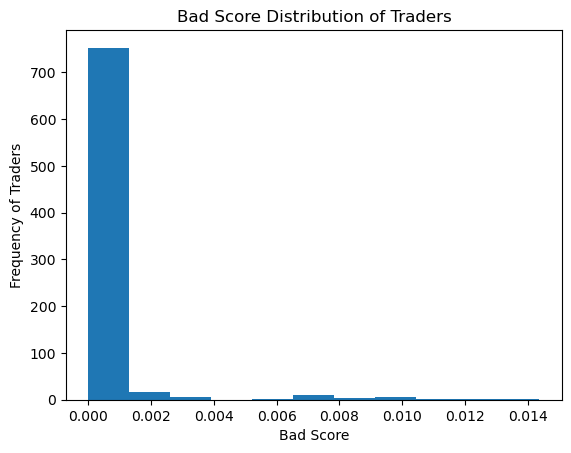

In [395]:
plt.hist(bad_scores , bins = 'auto')
plt.title("Bad Score Distribution of Traders")
plt.xlabel("Bad Score")
plt.ylabel("Frequency of Traders")
plt.show()

In [394]:
print("The top 20 bad traders with their bad scores are: ")
print(final_df.sort_values(by=['Bad Score'] , ascending=False).head(20))

The top 20 bad traders with their bad scores are: 
     Trader ID  Bad Score
10        1011   0.014371
33        1034   0.012130
290       1309   0.010926
38        1039   0.010221
144       1147   0.009874
203       1210   0.009721
97        1099   0.009514
6         1007   0.009255
73        1074   0.008793
41        1042   0.008758
159       1163   0.008222
432       1488   0.007847
75        1076   0.007560
363       1393   0.007500
647       1832   0.007500
248       1259   0.007500
552       1668   0.007500
628       1801   0.007500
246       1256   0.007500
44        1045   0.007500
